In [86]:
import pandas as pd 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# A look at the data 

In [88]:
# import deaths data
df_deaths = pd.read_csv('../data/new_covid19_deaths_italy.csv')
df_deaths.date = pd.to_datetime(df_deaths.date)
df_deaths = df_deaths.loc[df_deaths.date <= datetime(2020, 8, 1)]
df_deaths["new_deaths"] = df_deaths["total_deaths"].diff()
df_deaths["new_tests"] = df_deaths["tests"].diff()

df_deaths = df_deaths.loc[df_deaths.new_deaths.notnull()]

df_deaths.head()

,date,total_deaths,new_cases,tests,new_deaths,new_tests
1,2020-02-25,10,93,8623,3.0,4299.0
2,2020-02-26,12,78,9587,2.0,964.0
3,2020-02-27,17,250,12014,5.0,2427.0
4,2020-02-28,21,238,15695,4.0,3681.0
5,2020-02-29,29,240,18661,8.0,2966.0


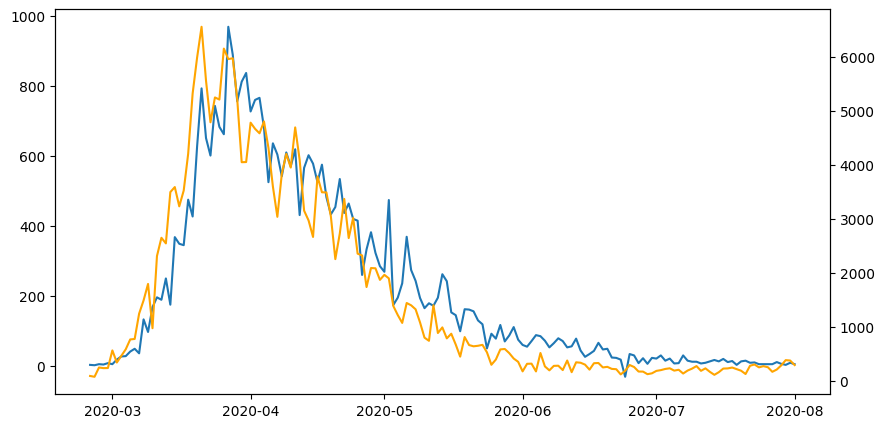

In [89]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_deaths.date, df_deaths.new_deaths)
ax2 = ax.twinx()

ax2.plot(df_deaths.date, df_deaths.new_cases, color="orange")

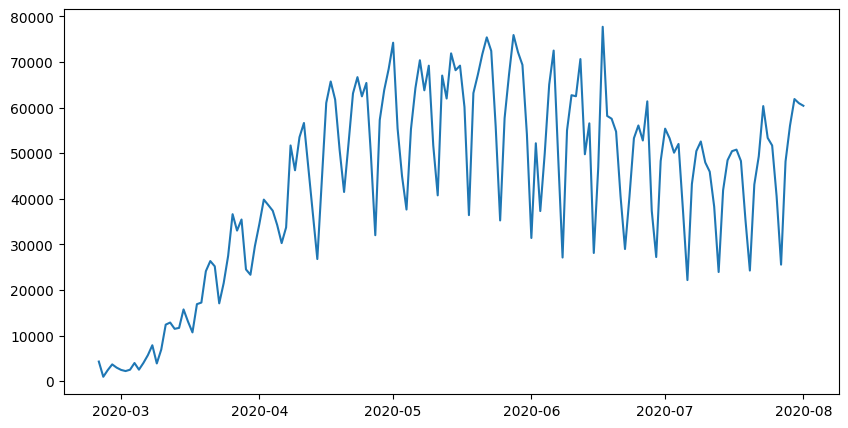

In [90]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_deaths.date, df_deaths.new_tests)

In [93]:
# import google mobility data
df_google = pd.read_csv("../data/2020_IT_Region_Mobility_Report.csv")
df_google["date"] = pd.to_datetime(df_google["date"])
df_google = df_google.loc[(df_google.date >= df_deaths.date.min()) & \
                          (df_google.date <= df_deaths.date.max())]
df_google["reduction"] = df_google[['retail_and_recreation_percent_change_from_baseline',
                                    'transit_stations_percent_change_from_baseline',
                                    'workplaces_percent_change_from_baseline']].mean(axis=1)
df_google = df_google.loc[df_google.date <= datetime(2020, 8, 1)]
df_google_ita = df_google.loc[(df_google.sub_region_1.isnull())]
df_google_ita.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,reduction
10,IT,Italy,NaN,NaN,NaN,NaN,NaN,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-25,-6.0,5.0,20.0,-18.0,-15.0,5.0,-13.000000
11,IT,Italy,NaN,NaN,NaN,NaN,NaN,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-26,-13.0,-5.0,-6.0,-23.0,-12.0,6.0,-16.000000
12,IT,Italy,NaN,NaN,NaN,NaN,NaN,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-27,-10.0,-3.0,-1.0,-22.0,-12.0,6.0,-14.666667
13,IT,Italy,NaN,NaN,NaN,NaN,NaN,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-28,-8.0,-2.0,11.0,-20.0,-12.0,5.0,-13.333333
14,IT,Italy,NaN,NaN,NaN,NaN,NaN,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-29,-10.0,-2.0,2.0,-16.0,-9.0,3.0,-11.666667


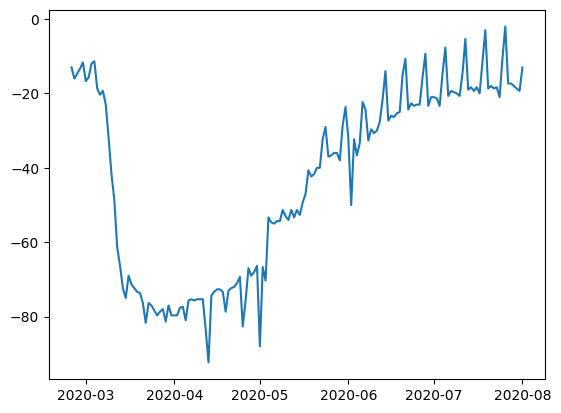

In [94]:
plt.plot(df_google_ita.date, df_google_ita.reduction)

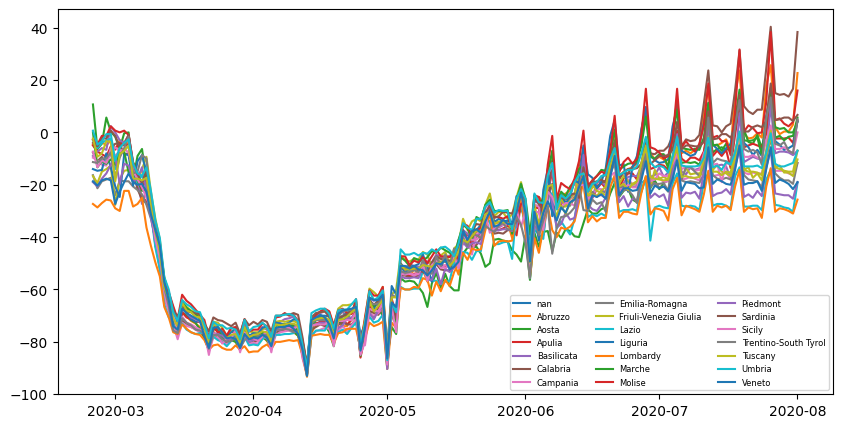

In [95]:
fig, ax = plt.subplots(figsize=(10, 5))

# by region 
for region in df_google.sub_region_1.unique():
    df_google_reg = df_google.loc[(df_google.sub_region_1 == region) & \
                                  (df_google.sub_region_2.isnull())]

    ax.plot(df_google_reg.date, df_google_reg.reduction, label=region)


plt.legend(fontsize=6, ncols=3)


# Modeling

In [96]:
def stochastic_seirD_age_structure(R0, 
                                   eps,
                                   mu, 
                                   C, 
                                   Nk, 
                                   I0_perc, 
                                   T, 
                                   reductions, 
                                   ifr, 
                                   Delta):
    """
    Function to simulate the stochastic SIR model with age structure.

    Parameters:
        R0 (float): Basic reproduction number
        eps (float): Inverse of of Incubation period 
        mu (float): Recovery rate
        C (array): Contact matrix
        Nk (array): Total population size by age group
        I0_perc (float): Fraction of number of infected individuals
        T (int): number of steps to simulate
        reductions (array): Array of reductions in contacts
        ifr (array): Infection fatality rate
        Delta (float): deaths delay

    Returns:
        S (array): Array of susceptible individuals over time and age groups
        E (array): Array of susceptible individuals over time and age groups
        I (array): Array of infected individuals over time and age groups
        R (array): Array of recovered individuals over time and age groups
        D (array): Array of deaths over time and age groups
    """

    I0 = int(Nk.sum() * I0_perc)   # initial number of infected individuals
    nage = len(C)                  # number of age groups
    S, E, I, R = np.zeros((T, nage)), np.zeros((T, nage)), np.zeros((T, nage)), np.zeros((T, nage))
    D0, D1, D2 = np.zeros((T, nage)), np.zeros((T, nage)), np.zeros((T, nage))

    # compute beta 
    beta = get_beta(R0, mu, C, Nk)
    
    # initialize compartments
    for k in range(nage):
        inf = int(I0 / nage)
        I[0, k] = int(inf / 2)
        E[0, k] = int(inf / 2)
        S[0, k] = Nk[k] - I[0, k]

    # simulate
    for t in np.arange(1, T, 1):
        S_next, E_next, I_next, R_next = S[t-1].copy(), E[t-1].copy(), I[t-1].copy(), R[t-1].copy()
        D0_next, D1_next, D2_next = D0[t-1].copy(), D1[t-1].copy(), D2[t-1].copy()
        for k in range(nage):
            
            new_exposed_k = np.random.binomial(S[t-1, k], reductions[t] * beta * np.sum(C[k, :] * I[t-1, :] / Nk))
            new_infectious_k = np.random.binomial(E[t-1, k], eps)

            leaving_I_k = np.random.binomial(I[t -1, k], mu * (1 - ifr[k]) + mu * ifr[k])
            new_recovered_k = np.random.binomial(leaving_I_k, mu * (1 - ifr[k]) / ( mu * (1 - ifr[k]) + mu * ifr[k]))
            new_D0_k = leaving_I_k - new_recovered_k

            new_D1_k = np.random.binomial(D0[t-1, k], 1. / (Delta / 2.))
            new_D2_k = np.random.binomial(D1[t-1, k], 1. / (Delta / 2.))

            S_next[k] = S[t-1, k] - new_exposed_k
            E_next[k] = E[t-1, k] + new_exposed_k - new_infectious_k
            I_next[k] = I[t-1, k] + new_infectious_k - new_recovered_k - new_D0_k
            R_next[k] = R[t-1, k] + new_recovered_k
            D0_next[k] = D0[t-1, k] + new_D0_k - new_D1_k
            D1_next[k] = D1[t-1, k] + new_D1_k - new_D2_k
            D2_next[k] = D2[t-1, k] + new_D2_k 
            
        S[t] = S_next
        E[t] = E_next
        I[t] = I_next
        R[t] = R_next
        D0[t] = D0_next
        D1[t] = D1_next
        D2[t] = D2_next
        
    return dict(S=np.array(S), 
                E=np.array(E), 
                I=np.array(I), 
                R=np.array(R), 
                D0=np.array(D0), 
                D1=np.array(D1),
                D2=np.array(D2))


def get_beta(R0, mu, contact_matrix, Nk): 
    contact_matrix_weighted = contact_matrix.copy()
    for i in range(contact_matrix.shape[0]):
        for j in range(contact_matrix.shape[1]):
            contact_matrix_weighted[i,j] = contact_matrix[i,j] * Nk[i] / Nk[j]

    rho = np.linalg.eigvals(contact_matrix_weighted).real.max()
    return R0 / rho * mu

In [97]:
# import population and contact matrix
pop_ita = pd.read_csv("../data/pop_ita.csv")
C_ita = np.load("../data/contact_matrix_italy.npz")["arr_0"]

In [98]:
# infection fatality rate (Verity et al)
ifr = [0.00161 / 100, # 0-4
        0.00161 / 100, # 5-9
        0.00695 / 100, # 10-14
        0.00695 / 100, # 15-19
        0.0309  / 100, # 20-24
        0.0309  / 100, # 25-29
        0.0844  / 100, # 30-34
        0.0844  / 100, # 35-39
        0.161   / 100, # 40-44
        0.161   / 100, # 45-49
        0.595   / 100, # 50-54
        0.595   / 100, # 55-59
        1.93    / 100, # 60-64
        1.93    / 100, # 65-69
        4.28    / 100, # 70-74
        6.04    / 100] # 75+

In [112]:
simulation_dates = df_deaths.date.values

results = stochastic_seirD_age_structure(R0=3., 
                                         eps=1./4.,
                                         mu=1./2.5, 
                                         C=C_ita, 
                                         Nk=pop_ita.Value.values, 
                                         I0_perc=0.001, 
                                         T=len(simulation_dates), 
                                         reductions=((1 + df_google_ita["reduction"]/100)**2).values, 
                                         ifr=ifr, 
                                         Delta=14.)

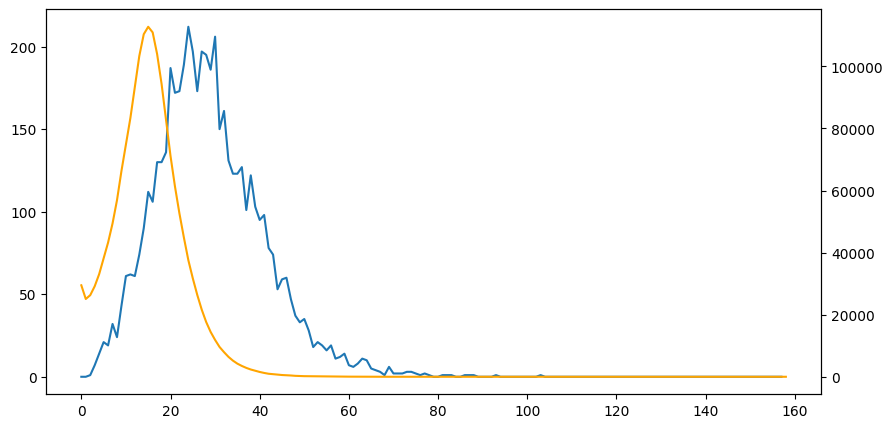

In [113]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.diff(np.sum(results["D2"], axis=1)), label="Deaths")
ax2 = ax.twinx()
ax2.plot(np.sum(results["I"], axis=1), label="Infected", color="orange")

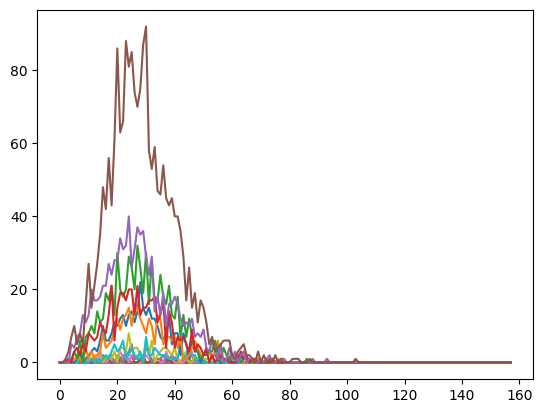

In [114]:
plt.plot(np.diff(results["D2"], axis=0));

# Calibration

In [115]:
import pyabc
import uuid
from pyabc.sampler import MulticoreEvalParallelSampler
from pyabc import RV, Distribution, MultivariateNormalTransition, AggregatedTransition
import os
import pickle as pkl

def wmape_pyabc(sim_data, actual_data):
    return np.sum(np.abs(actual_data['data'] - sim_data['data'])) / np.sum(np.abs(actual_data['data']))
    
def compute_quantiles(samples: np.ndarray, quantiles: np.ndarray = np.arange(0.01, 1.0, 0.01)) -> pd.DataFrame:
    df_samples = pd.DataFrame() 
    for q in quantiles:
        df_samples[str(np.round(q, 2))] = np.quantile(samples, axis=0, q=np.round(q, 2))
    
    # additional quantiles and aggregated measures
    df_samples["0.025"] = np.quantile(samples, axis=0, q=0.025)
    df_samples["0.975"] = np.quantile(samples, axis=0, q=0.975)
    df_samples["min"] = np.min(samples, axis=0)
    df_samples["max"] = np.max(samples, axis=0)
    return df_samples

def calibration(epimodel, 
                prior, 
                params, 
                distance,
                observations,
                transitions,
                simulation_dates,
                population_size : int = 1000,
                minimum_epsilon : float = 0.3, 
                max_nr_populations : int = 10, 
                n_procs : int = 8, 
                filename : str = '', 
                folder_name : str = "calibration_runs"):

    """
    Run ABC calibration on given model and prior 
    Parameters
    ----------
        @param epimodel (Callable): epidemic model 
        @param prior (pyabc.Distribution): prior distribution
        @param params (dict): dictionary of fixed parameters value
        @param distance (Callable): distance function to use 
        @param observations (List[float]): real observations 
        @param transitions (pyabc.AggregatedTransition): next gen. perturbation transitions
        @param population_size (int): size of the population of a given generation
        @param minimum_epsilon (float): minimum tolerance (if reached calibration stops)
        @param max_nr_population (int): maximum number of generations
        @param filename (str): name of the files used to store ABC results
        @param folder_name (str): name of the folder where ABC results are stored
    Returns
    -------
        @return: returns ABC history
    """


    def make_model(epimodel, param): 
        def model(p): 
            # run model 
            results = epimodel(**p, **param)
            return {'data': np.diff(np.sum(results["D2"], axis=1))}
        return model

    if filename == '':
        filename = str(uuid.uuid4())

    abc = pyabc.ABCSMC(make_model(epimodel, params), 
                       prior, 
                       distance, 
                       transitions=transitions, 
                       population_size=population_size,
                       sampler=MulticoreEvalParallelSampler(n_procs=n_procs))
    
    db_path = os.path.join(f'./{folder_name}/dbs/', f"{filename}.db")
    abc.new("sqlite:///" + db_path, {"data": observations})
    history = abc.run(minimum_epsilon=minimum_epsilon, 
                      max_nr_populations=max_nr_populations)
    
    with open(os.path.join(f'./{folder_name}/abc_history/', f"{filename}.pkl"), 'wb') as file:
        pkl.dump(history, file)

    # save posterior distribution
    history.get_distribution()[0].to_csv(os.path.join(f"./{folder_name}/posteriors/", f"{filename}_posterior_distributions.csv"))  

    # compute quantiles and save samples
    raw_samples = np.array([d["data"] for d in history.get_weighted_sum_stats()[1]])
    df_samples = compute_quantiles(raw_samples)
    df_samples["date"] = simulation_dates
    df_samples["data"] = history.observed_sum_stat()["data"]
    df_samples.to_csv(os.path.join(f"./{folder_name}/posteriors/", f"{filename}_posterior_quantiles.csv"), index=False)  
    np.savez_compressed(os.path.join(f"./{folder_name}/posteriors/", f"{filename}_posterior_samples.npz"), raw_samples)

    return history, abc

In [118]:
calibration(epimodel=stochastic_seirD_age_structure, 
            prior=Distribution(R0=RV("uniform", 1.8, 4.0 - 1.8), 
                               I0_perc=RV("uniform", 0.01 / 100., 0.5 / 100. - 0.01 / 100.), 
                               Delta=RV("uniform", 7., 28. - 7.)), 
            params=dict(eps=1./4.,
                        mu=1./2.5, 
                        C=C_ita, 
                        Nk=pop_ita.Value.values, 
                        T=len(simulation_dates), 
                        reductions=((1 + df_google_ita["reduction"]/100)**2).values, 
                        ifr=ifr), 
            distance=wmape_pyabc,
            observations=df_deaths.new_deaths.values[1:],
            transitions=AggregatedTransition(mapping=dict(R0=MultivariateNormalTransition(),
                                                          I0_perc=MultivariateNormalTransition(),
                                                          Delta=MultivariateNormalTransition())),
            simulation_dates=df_deaths.new_deaths.values[1:])

ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2024-05-15 11:24:26>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 7.70370476e-01.
ABC INFO: Accepted: 1000 / 2127 = 4.7015e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 6.25902040e-01.
ABC INFO: Accepted: 1000 / 1994 = 5.0150e-01, ESS: 9.2123e+02.
ABC INFO: t: 2, eps: 5.00418725e-01.
ABC INFO: Accepted: 1000 / 1956 = 5.1125e-01, ESS: 8.9251e+02.
ABC INFO: t: 3, eps: 3.91890320e-01.
ABC INFO: Accepted: 1000 / 2237 = 4.4703e-01, ESS: 8.8023e+02.
ABC INFO: t: 4, eps: 3.15246047e-01.
ABC INFO: Accepted: 1000 / 2400 = 4.1667e-01, ESS: 8.1586e+02.
ABC INFO: t: 5, eps: 2.63630143e-01.
ABC INFO: Accepted: 1000 / 2787 = 3.5881e-01, ESS: 8.0140e+02.
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=1, duration=0:04:43.783179, end_time=2024-05-15 11:29:10>
/var/folders/5q/w1ww7ss174bb2jxkr7jkj3rw0000gp/T/ipykernel_1665/3215240475.py:18: PerformanceWarning: DataFrame i

(<pyabc.storage.history.History at 0x7f8b33927610>,
 <pyabc.inference.smc.ABCSMC at 0x7f8b329d16a0>)

In [ ]:
calibration(epimodel=stochastic_seirD_age_structure, 
            prior=Distribution(R0=RV("uniform", 1.8, 4.0 - 1.8), 
                               I0_perc=RV("uniform", 0.01 / 100., 0.5 / 100. - 0.01 / 100.), 
                               Delta=RV("uniform", 7., 28. - 7.)), 
            params=dict(eps=1./4.,
                        mu=1./2.5, 
                        C=C_ita, 
                        Nk=pop_ita.Value.values, 
                        T=len(simulation_dates), 
                        reductions=((1 + df_google_ita["reduction"]/100)**2).values, 
                        ifr=ifr), 
            distance=wmape_pyabc,
            observations=df_deaths.new_deaths.values[1:],
            transitions=AggregatedTransition(mapping=dict(R0=MultivariateNormalTransition(),
                                                          I0_perc=MultivariateNormalTransition(),
                                                          Delta=MultivariateNormalTransition())),
            simulation_dates=df_deaths.new_deaths.values[1:])

ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2024-05-15 11:24:26>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 7.70370476e-01.
ABC INFO: Accepted: 1000 / 2127 = 4.7015e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 6.25902040e-01.
ABC INFO: Accepted: 1000 / 1994 = 5.0150e-01, ESS: 9.2123e+02.
ABC INFO: t: 2, eps: 5.00418725e-01.
ABC INFO: Accepted: 1000 / 1956 = 5.1125e-01, ESS: 8.9251e+02.
ABC INFO: t: 3, eps: 3.91890320e-01.
ABC INFO: Accepted: 1000 / 2237 = 4.4703e-01, ESS: 8.8023e+02.
ABC INFO: t: 4, eps: 3.15246047e-01.
ABC INFO: Accepted: 1000 / 2400 = 4.1667e-01, ESS: 8.1586e+02.
ABC INFO: t: 5, eps: 2.63630143e-01.
ABC INFO: Accepted: 1000 / 2787 = 3.5881e-01, ESS: 8.0140e+02.
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=1, duration=0:04:43.783179, end_time=2024-05-15 11:29:10>
/var/folders/5q/w1ww7ss174bb2jxkr7jkj3rw0000gp/T/ipykernel_1665/3215240475.py:18: PerformanceWarning: DataFrame i

(<pyabc.storage.history.History at 0x7f8b33927610>,
 <pyabc.inference.smc.ABCSMC at 0x7f8b329d16a0>)

In [119]:
df_quantiles = pd.read_csv("./calibration_runs/posteriors/78bff828-459f-4a93-9604-1cd83696a9c1_posterior_quantiles.csv")
df_quantiles.head()

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,...,0.96,0.97,0.98,0.99,0.025,0.975,min,max,date,data
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,2.0,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,5.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,6.0,6.0,6.00,7.00,0.0,6.0,0.0,8.0,4.0,4.0
3,1.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,...,12.0,13.0,13.00,14.00,2.0,13.0,0.0,16.0,8.0,8.0
4,5.0,6.0,6.0,6.0,7.0,7.0,7.0,8.0,8.0,8.0,...,21.0,22.0,22.02,24.01,6.0,22.0,3.0,30.0,5.0,5.0


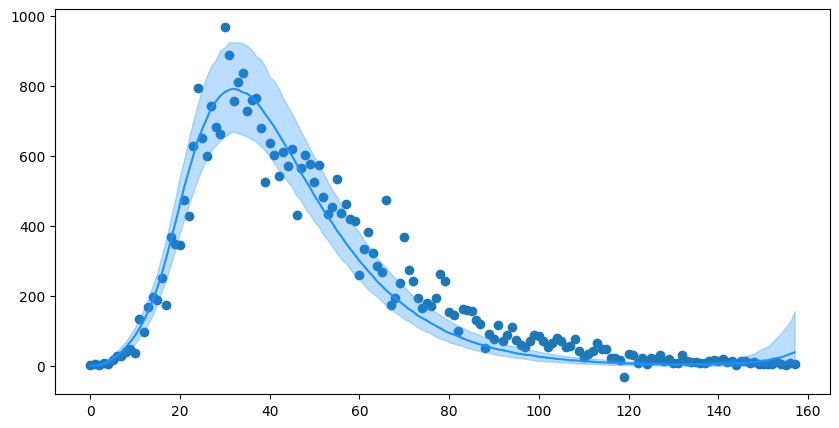

In [126]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(range(len(df_quantiles)), df_quantiles.data, label="Observed")
ax.plot(df_quantiles["0.5"], label="median", color="dodgerblue")
ax.fill_between(range(len(df_quantiles)), df_quantiles["0.05"], df_quantiles["0.95"], alpha=0.3, color="dodgerblue", label="90% CI")


In [127]:
posterior = pd.read_csv("./calibration_runs/posteriors/78bff828-459f-4a93-9604-1cd83696a9c1_posterior_distributions.csv")
posterior.head()

,id,Delta,I0_perc,R0
0,5002,25.694768,0.003414,3.667017
1,5003,26.693578,0.002900,3.756987
2,5004,27.094271,0.004131,3.472411
3,5005,26.947013,0.004009,3.586164
4,5006,27.777986,0.004677,3.277226


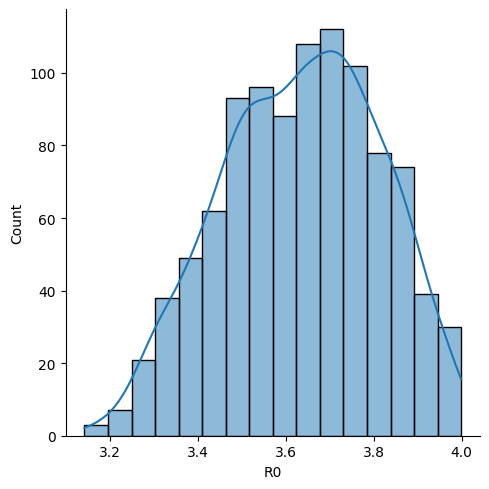

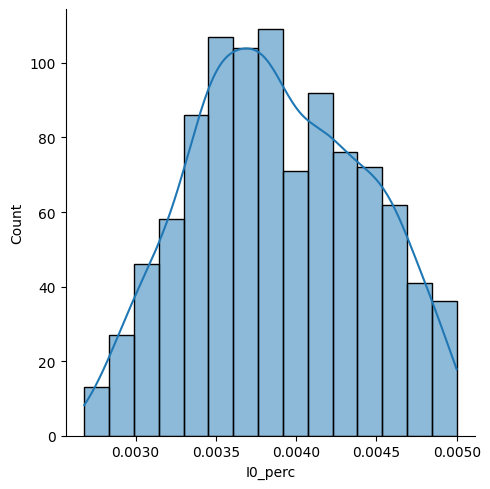

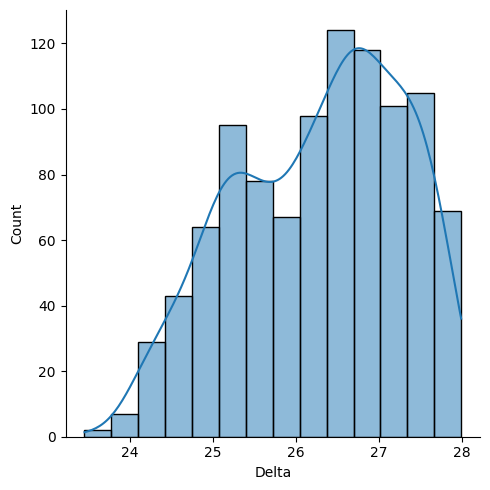

In [130]:
import seaborn as sns
sns.displot(posterior["R0"], kde=True)
sns.displot(posterior["I0_perc"], kde=True)
sns.displot(posterior["Delta"], kde=True)

